In [3]:
import pandas as pd
import numpy as np
import plot_params
import graphviz
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

In [4]:
df = pd.read_csv("mushrooms.csv")
plot_params.apply_rcparams()

In [5]:
df.head()


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [6]:
print(df.isnull().sum())

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64


In [7]:
df = df.rename(columns={'class': 'edibility'})
# class is a very dangerous name in python change to edibility

In [8]:
df_encoded = pd.get_dummies(df, columns=df.columns[1:], drop_first=True)
label_encoder = preprocessing.LabelEncoder()
df_encoded['edibility'] = label_encoder.fit_transform(df['edibility'])

In [9]:
df_encoded.head()

,edibility,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_g,cap-surface_s,cap-surface_y,cap-color_c,...,population_n,population_s,population_v,population_y,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,1,0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [10]:
clf = tree.DecisionTreeClassifier()
X = df_encoded.iloc[:, 5:20]
Y = df_encoded['edibility']
X_train, X_test, Y_train, Y_test = \
    train_test_split(X, Y, test_size=0.2, random_state=42)
clf = clf.fit(X_train,Y_train)

In [11]:
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("shroom_odor")

'shroom_odor.pdf'

In [12]:
Y_pred = clf.predict(X_test)
accuracy = metrics.accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.87


In [13]:
confuse = metrics.confusion_matrix(Y_test, Y_pred)

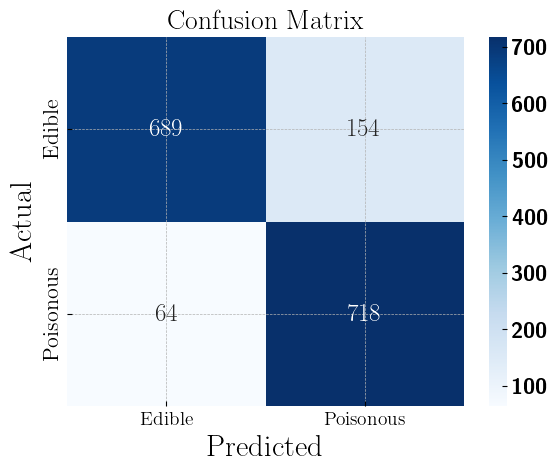

In [14]:
sns.heatmap(confuse, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Edible', 'Poisonous'],
            yticklabels=['Edible', 'Poisonous'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [15]:
def single_classifier(classifier_index):
    clf = tree.DecisionTreeClassifier()
    X = df_encoded.iloc[:, [classifier_index]]
    Y = df_encoded['edibility']
    X_train, X_test, Y_train, Y_test = \
        train_test_split(X, Y, test_size=0.2, random_state=42)
    clf = clf.fit(X_train,Y_train)

    Y_pred = clf.predict(X_test)
    accuracy = metrics.accuracy_score(Y_test, Y_pred)
    return accuracy

In [16]:
ids = np.linspace(1,len(df_encoded.T)-1, len(df_encoded.T)-1).astype(int)
classi = [df_encoded.columns[i] for i in ids]
accurs = [single_classifier(i) for i in ids]

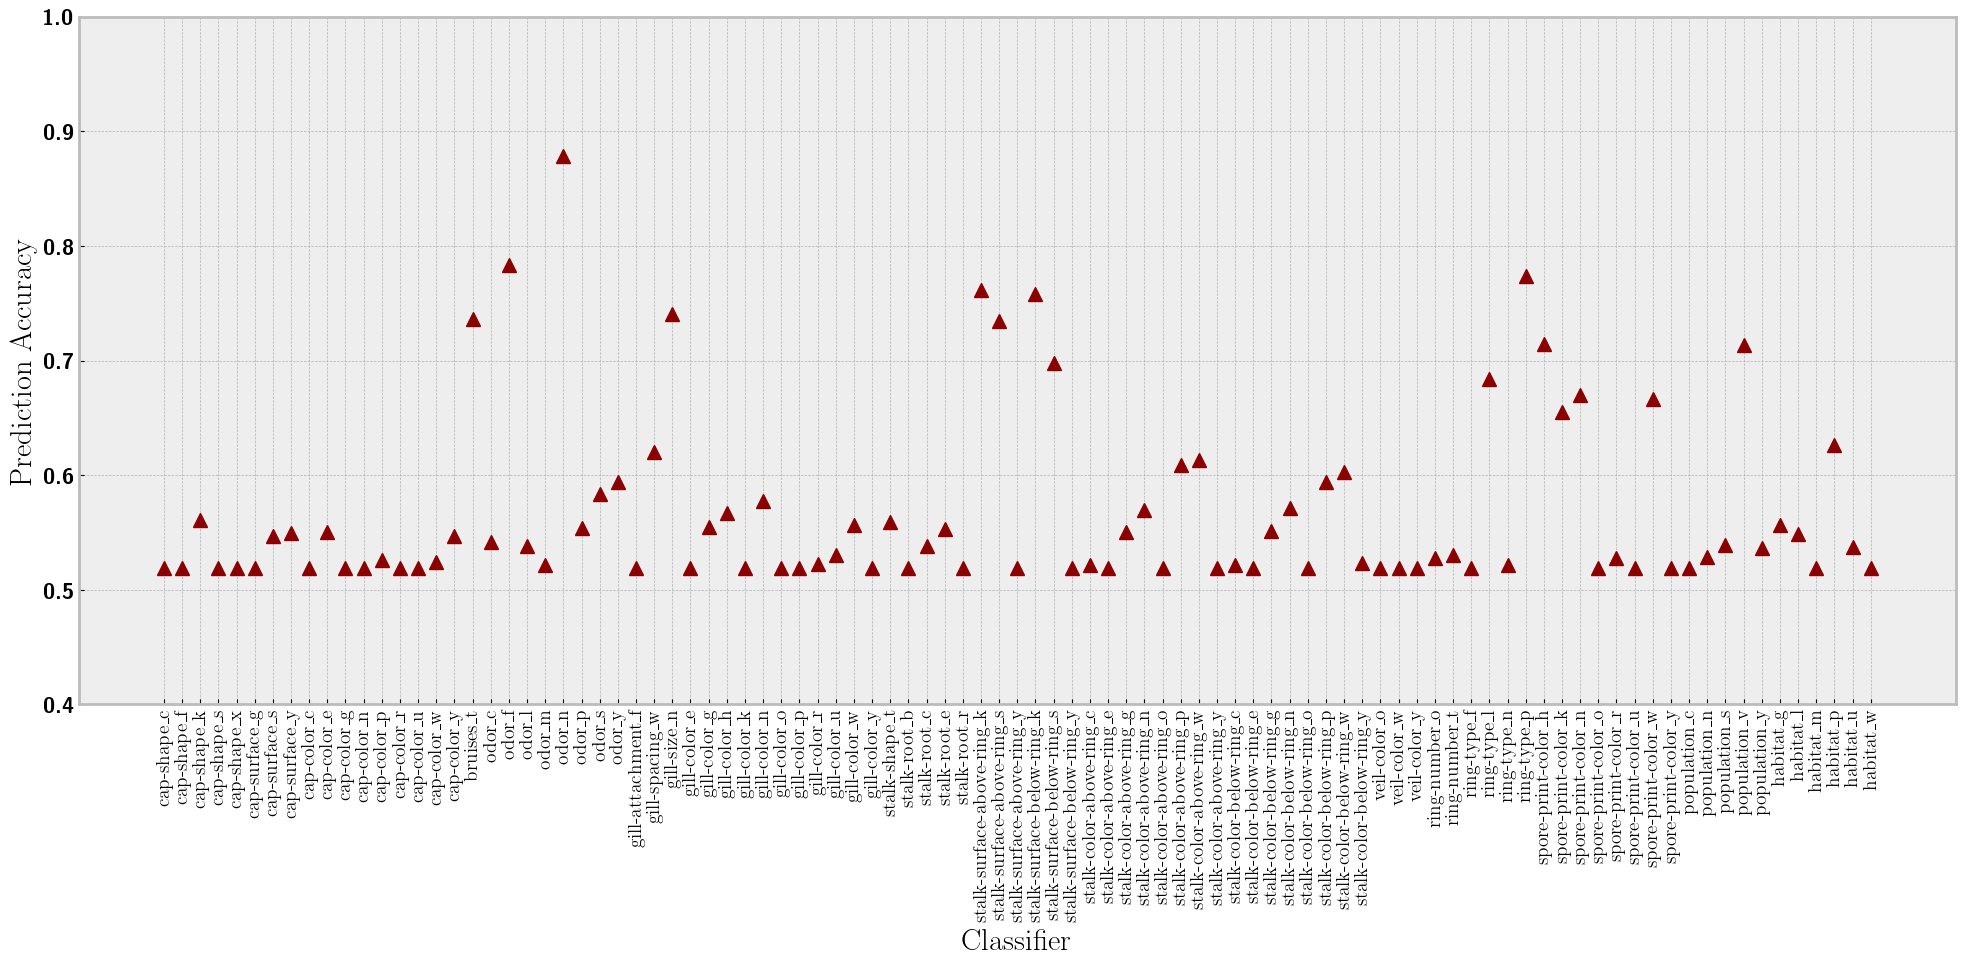

In [17]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(classi, accurs, '^', color='darkred', markersize=10)
ax.set_ylabel("Prediction Accuracy")
ax.set_xlabel("Classifier")
ax.set_ylim(0.4,1.)
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

In [18]:
count = 0
for row in df.itertuples(index=True, name='Row'):
    if row.edibility == 'p' and row.odor == 'n':
        count +=1
print(count)

120


In [19]:
max_idx = accurs.index(max(accurs))

In [20]:
def double_classifier(classifier_index):
    clf = tree.DecisionTreeClassifier()
    X = df_encoded.iloc[:, [classifier_index, max_idx]]
    Y = df_encoded['edibility']
    X_train, X_test, Y_train, Y_test = \
        train_test_split(X, Y, test_size=0.2, random_state=42)
    clf = clf.fit(X_train,Y_train)

    Y_pred = clf.predict(X_test)
    accuracy = metrics.accuracy_score(Y_test, Y_pred)
    return accuracy

In [21]:
accurs_2 = [double_classifier(i) for i in ids]
accurs_diff = [(accurs_2[i] - accurs[i]) for i in range(len(accurs_2))]

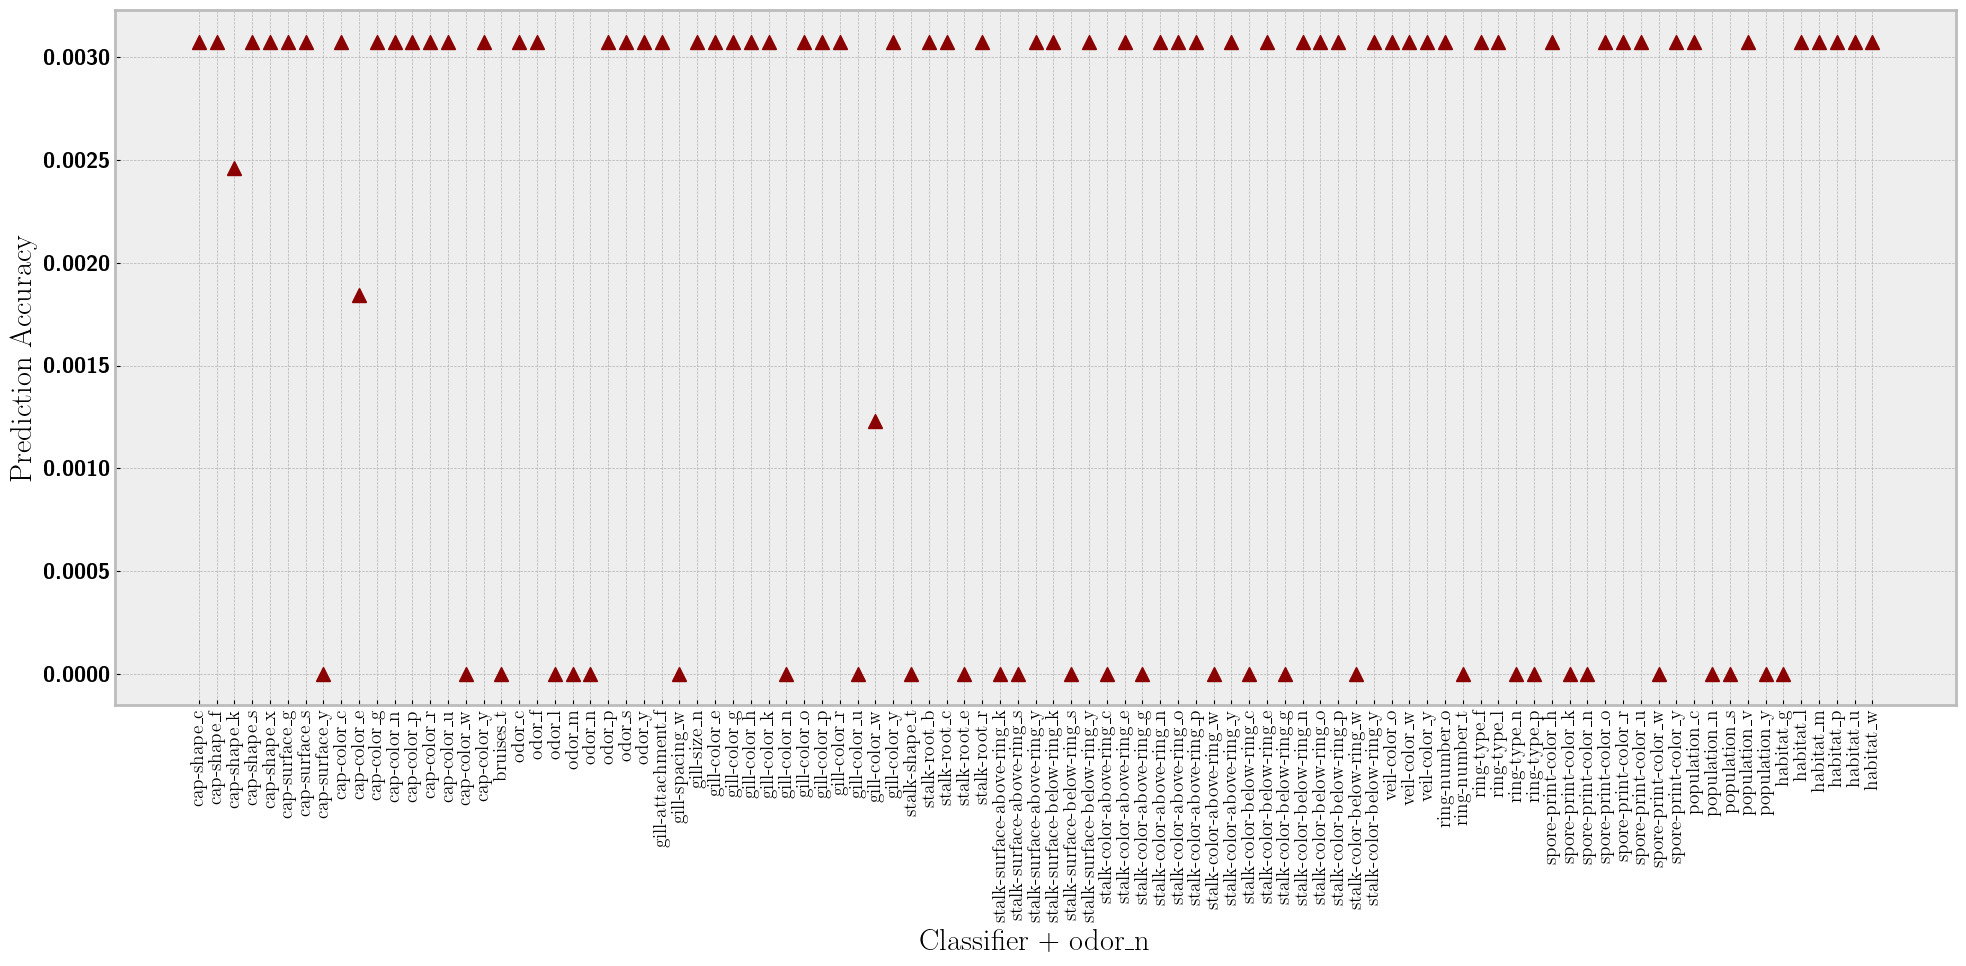

In [22]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(classi, accurs_diff, '^', color='darkred', markersize=10)
ax.set_ylabel("Prediction Accuracy")
ax.set_xlabel("Classifier + odor_n")
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

In [30]:
model = CatBoostClassifier(cat_features=['odor', 'odor'], verbose=0)
X = df.iloc[:, [5,5]]
Y = df['edibility']
X_train, X_test, Y_train, Y_test = \
    train_test_split(X, Y, test_size=0.2, random_state=42)
cat = model.fit(X_train, Y_train)
Y_pred = cat.predict(X_test)
accuracy = metrics.accuracy_score(Y_test, Y_pred)
print(accuracy)

CatBoostError: catboost/libs/data/features_layout.cpp:124: All feature names should be different, but 'odor' used more than once.

In [24]:
confuse = metrics.confusion_matrix(Y_test, Y_pred)

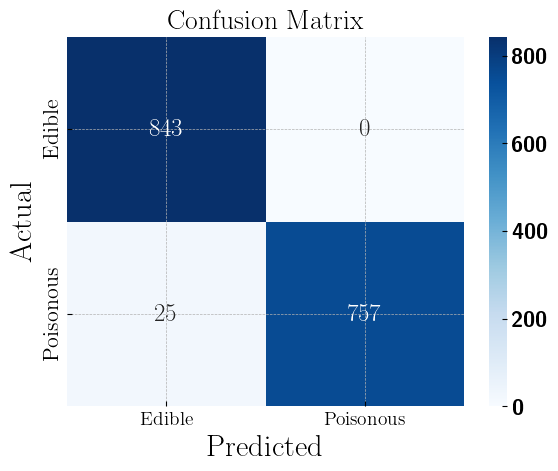

In [25]:
sns.heatmap(confuse, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Edible', 'Poisonous'],
            yticklabels=['Edible', 'Poisonous'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()